In [1]:
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import concatenate
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_excel('CX2_16_1_30_12.xlsx',sheet_name='Channel_1-006')
df.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000283,2012-01-12 15:54:08,30.000284,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
1,2,60.015499,2012-01-12 15:54:38,60.015500,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
2,3,90.030861,2012-01-12 15:55:08,90.030861,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
3,4,120.014716,2012-01-12 15:55:38,120.014716,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
4,5,150.171587,2012-01-12 15:56:08,30.015424,3,1,0.0,4.117935,0.000026,0.0,0.000108,0.0,0.0,0.0,0,0,0


In [3]:
# Grouping rows by the cycle index.
group = df.groupby(['Cycle_Index']).count()
group.head()
group['Cumu_count'] = pd.Series(np.random.randn(len(group)), index=group.index)
group['Cumu_count'] = group['Data_Point'].cumsum()

In [4]:
group.head(20)

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Cumu_count
Cycle_Index,,,,,,,,,,,,,,,,,
1,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217
2,364,364,364,364,364,364,364,364,364,364,364,364,364,364,364,364,581
3,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361,942
4,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,1304
5,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,1664
6,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,2024
7,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,2384
8,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,2743
9,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,3100


In [5]:
df['Charge'] = pd.Series(np.random.randn(len(df)), index=df.index)
df['discharge'] = pd.Series(np.random.randn(len(df)), index=df.index)
cycle = []
cycle = group['Cumu_count']
df['Charge'][0:cycle[1]] = df['Charge_Capacity(Ah)'][0:cycle[1]]
df['discharge'][0:cycle[1]] = df['Discharge_Capacity(Ah)'][0:cycle[1]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# Converting cumulative charge capacity data to individual cycle data.
for i in range(1,len(cycle)):
    df['Charge'][cycle[i]:cycle[i+1]] = df['Charge_Capacity(Ah)'][cycle[i]:cycle[i+1]]-df['Charge_Capacity(Ah)'][cycle[i]]
    df['discharge'][cycle[i]:cycle[i+1]] = df['Discharge_Capacity(Ah)'][cycle[i]:cycle[i+1]]-df['Discharge_Capacity(Ah)'][cycle[i]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


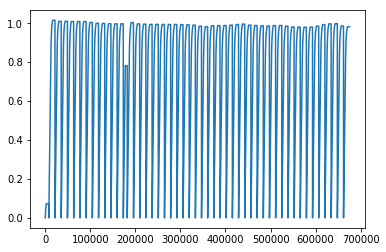

In [7]:
plt.plot(df['Test_Time(s)'],df['Charge'])

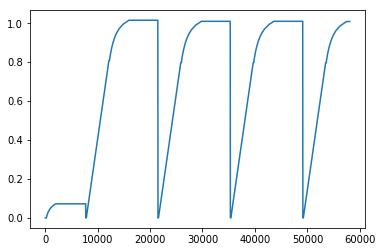

In [8]:
plt.plot(df['Test_Time(s)'][0:1500],df['Charge'][0:1500])

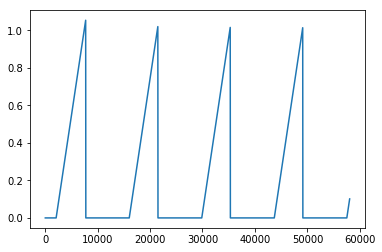

In [9]:
plt.plot(df['Test_Time(s)'][0:1500],df['discharge'][0:1500])

Text(0, 0.5, 'Voltage(V)')

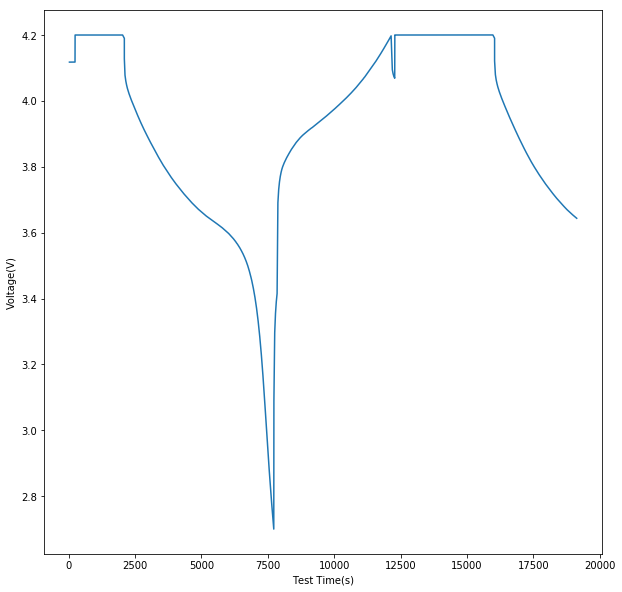

In [10]:
fig, ax = plt.subplots(1,figsize=(10,10))
plt.plot(df['Test_Time(s)'][:500],df['Voltage(V)'][:500])

plt.xlabel('Test Time(s)')
plt.ylabel('Voltage(V)')

Text(0, 0.5, 'Current(A)')

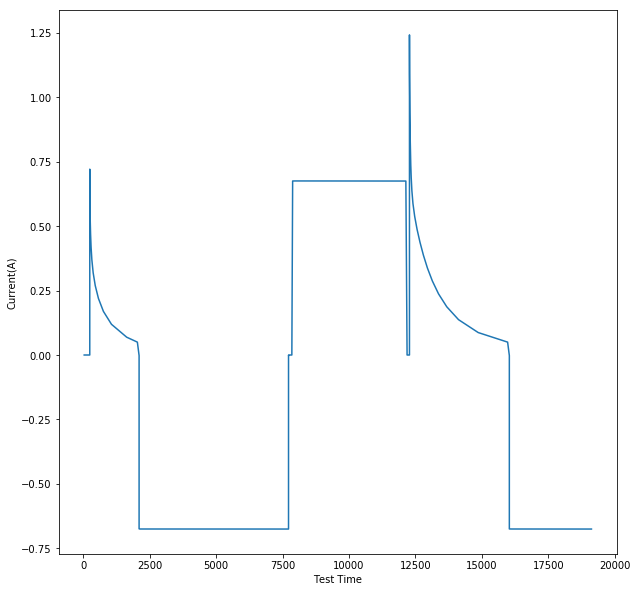

In [11]:
fig, ax = plt.subplots(1,figsize=(10,10))
plt.plot(df['Test_Time(s)'][:500],df['Current(A)'][:500])
plt.xlabel('Test Time')
plt.ylabel('Current(A)')

In [12]:
df['Voltage(V)'].min()

2.6998608112335205

In [13]:
df['Voltage(V)'].max()

4.2005510330200195

Text(0, 0.5, 'Discharge capacity(Ah)')

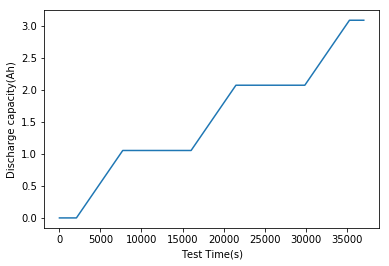

In [14]:
plt.plot(df['Test_Time(s)'][0:1000],df['Discharge_Capacity(Ah)'][0:1000])
plt.xlabel('Test Time(s)')
plt.ylabel('Discharge capacity(Ah)')

Text(0, 0.5, 'Discharge capacity(Ah)')

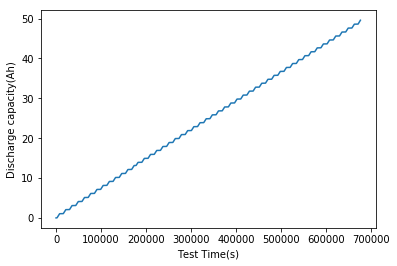

In [15]:
plt.plot(df['Test_Time(s)'],df['Discharge_Capacity(Ah)'])

plt.xlabel('Test Time(s)')
plt.ylabel('Discharge capacity(Ah)')

Text(0, 0.5, 'Internal Resistance(Ohm)')

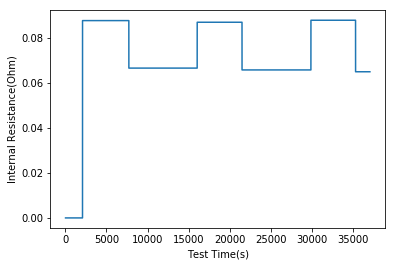

In [16]:
plt.plot(df['Test_Time(s)'][:1000],df['Internal_Resistance(Ohm)'][:1000])
plt.xlabel('Test Time(s)')
plt.ylabel('Internal Resistance(Ohm)')

In [17]:
df.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Charge,discharge
0,1,30.000283,2012-01-12 15:54:08,30.000284,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0,0.000000,0.0
1,2,60.015499,2012-01-12 15:54:38,60.015500,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0,0.000000,0.0
2,3,90.030861,2012-01-12 15:55:08,90.030861,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0,0.000000,0.0
3,4,120.014716,2012-01-12 15:55:38,120.014716,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0,0.000000,0.0
4,5,150.171587,2012-01-12 15:56:08,30.015424,3,1,0.0,4.117935,0.000026,0.0,0.000108,0.0,0.0,0.0,0,0,0,0.000026,0.0


In [18]:
# Dropping additional columns 
cycle_data = df.drop(['Data_Point','Internal_Resistance(Ohm)','Step_Index','Step_Time(s)','Cycle_Index','Charge_Capacity(Ah)','Discharge_Capacity(Ah)','Charge_Energy(Wh)','Discharge_Energy(Wh)','dV/dt(V/s)','Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)'],axis=1)
cycle_data['Capacity'] = pd.Series(np.random.randn(len(cycle_data)), index=cycle_data.index)
# Combining charge and discharge capacities to calculate net charge capacity of the battery.
cycle_data['Capacity'] = cycle_data['Charge'] - cycle_data['discharge']

In [19]:
cycle_data.set_index('Date_Time',inplace=True)

In [20]:
cycle_data.head()

,Test_Time(s),Current(A),Voltage(V),Charge,discharge,Capacity
Date_Time,,,,,,
2012-01-12 15:54:08,30.000283,0.0,4.117773,0.000000,0.0,0.000000
2012-01-12 15:54:38,60.015499,0.0,4.117773,0.000000,0.0,0.000000
2012-01-12 15:55:08,90.030861,0.0,4.117773,0.000000,0.0,0.000000
2012-01-12 15:55:38,120.014716,0.0,4.117773,0.000000,0.0,0.000000
2012-01-12 15:56:08,150.171587,0.0,4.117935,0.000026,0.0,0.000026


In [21]:
# Dataframe for testing and training.
model_data = cycle_data.drop(['Charge','discharge','Test_Time(s)'],axis=1)

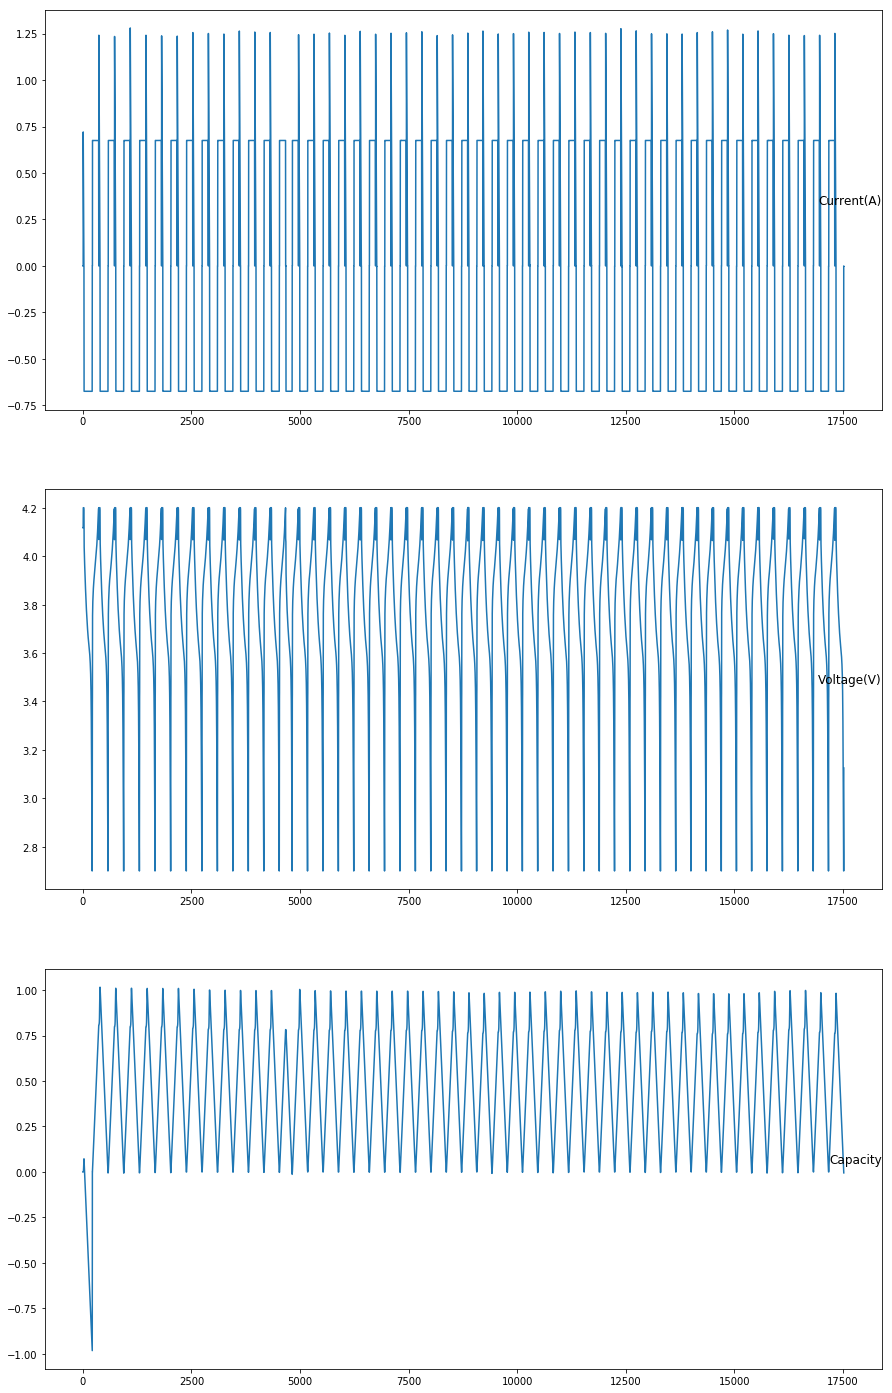

In [22]:
# Ignoring the first cycle (only discharge)
plot_values = model_data.values
# Specifying columns to be plotted
groups = [0,1,2]
i = 1
# plot each column
plt.figure(figsize=[15,25])
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(plot_values[:,group])
    plt.title(model_data.columns[group], y = 0.5, loc='right')
    i +=1
plt.show()

In [23]:
plot_values[:,1]

array([4.11777306, 4.11777306, 4.11777306, ..., 2.69986081, 2.76319957,
       3.12525082])

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# integer encode direction
# encoder = LabelEncoder()
# plot_values[:,4] = encoder.fit_transform(plot_values[:,5])
plot_values = plot_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(plot_values)
# frame as supervised learning
data = series_to_supervised(scaled, 1, 1)
data.head()
data.drop(data.columns[[3,4]],axis=1,inplace=True)
print(data.head(5))

   var1(t-1)  var2(t-1)  var3(t-1)   var3(t)
1   0.345243   0.944840   0.491709  0.491709
2   0.345243   0.944840   0.491709  0.491709
3   0.345243   0.944840   0.491709  0.491709
4   0.345243   0.944840   0.491709  0.491722
5   0.345243   0.944948   0.491722  0.491722


In [25]:
# Splitting the data into training and testing data
train,test = train_test_split(data, test_size=0.2, random_state=944)
# split into input and outputs
train_X, train_y = train[train.columns[0:3]].values, train[train.columns[3]].values
test_X, test_y = test[test.columns[0:3]].values, test[test.columns[3]].values
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14014, 1, 3) (14014,) (3504, 1, 3) (3504,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


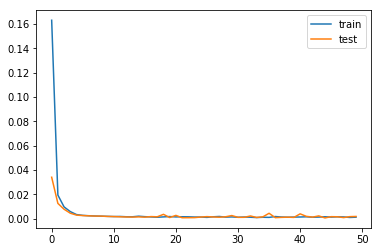

In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,1:]), axis=1)
inv_y_trans = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.145


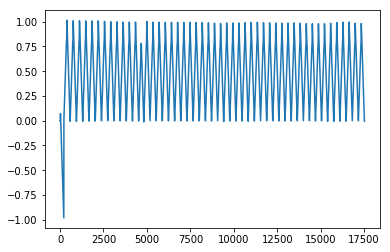

In [33]:
# Plotting original capacity data
plt.plot(np.arange(0,17519,1),cycle_data['Capacity'])

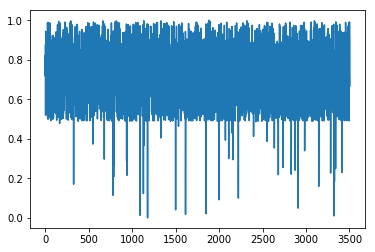

In [41]:
#Plotting the test values
plt.plot(np.arange(0,3504,1),test_y)

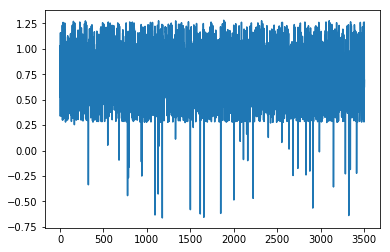

In [40]:
#Plotting predicted values
plt.plot(np.arange(0,3504,1),inv_yhat)